> __Purpose:__ This NB tests a CNN in the agglomerative model clustering procedure. With later finetuning. Uses the previously developed PyTorch code

In [16]:
model_str = "CNN"

In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
import torch

np.random.seed(42) 

from moments_engr import *
from agglo_model_clust import *
from DNN_FT_funcs import *
from DNN_AMC_funcs import *

In [2]:
path1 = 'C:\\Users\\kdmen\\Box\\Meta_Gesture_2024\\saved_datasets\\filtered_datasets\\$BStand_EMG_df.pkl'

with open(path1, 'rb') as file:
    raw_userdef_data_df = pickle.load(file)  # (204800, 19)

print(raw_userdef_data_df.shape)
raw_userdef_data_df.head()

(204800, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [3]:
# STEP 1: Train a classification model on every single individual user

userdef_df = raw_userdef_data_df.groupby(['Participant', 'Gesture_ID', 'Gesture_Num']).apply(create_feature_vectors)
#output is df with particpant, gesture_ID, gesture_num and feature (holds 80 len vector)
userdef_df = userdef_df.reset_index(drop=True)

#convert Gesture_ID to numerical with new Gesture_Encoded column
label_encoder = LabelEncoder()
userdef_df['Gesture_Encoded'] = label_encoder.fit_transform(userdef_df['Gesture_ID'])

label_encoder2 = LabelEncoder()
userdef_df['Cluster_ID'] = label_encoder2.fit_transform(userdef_df['Participant'])

print(userdef_df.shape)
userdef_df.head()

(3200, 6)


,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,Cluster_ID
0,P004,close,1,"[[6.079045311063784], [-7.551458873254243], [-...",0,0
1,P004,close,10,"[[5.994789910363704], [-7.978871468164499], [-...",0,0
2,P004,close,2,"[[6.010193380499154], [-7.7063875553339], [-20...",0,0
3,P004,close,3,"[[5.8212078257286874], [-7.463908156909893], [...",0,0
4,P004,close,4,"[[5.974675085061773], [-7.945111601415482], [-...",0,0


In [4]:
all_participants = userdef_df['Participant'].unique()
# Shuffle the participants
np.random.shuffle(all_participants)
# Split into two groups
#train_participants = all_participants[:24]  # First 24 participants
test_participants = all_participants[24:]  # Remaining 8 participants

In [5]:
# Prepare data
data_splits = prepare_data(
    userdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=8, finetuning_trials_per_gesture=3,
)

In [6]:
data_splits.keys()

dict_keys(['train', 'intra_subject_test', 'novel_trainFT', 'cross_subject_test'])

In [7]:
data_splits['train'].keys()

dict_keys(['feature', 'labels', 'participant_ids'])

In [8]:
features_df = pd.DataFrame(data_splits['train']['feature'])
# Create a new column 'features' that contains all 80 columns as lists
features_df['feature'] = features_df.apply(lambda row: row.tolist(), axis=1)
# Keep only the new combined column
features_df = features_df[['feature']]
# Combine with labels and participant_ids into a single DataFrame
train_df = pd.concat([features_df, pd.Series(data_splits['train']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['train']['participant_ids'], name='participant_ids')], axis=1)
label_encoder = LabelEncoder()
train_df['Cluster_ID'] = label_encoder.fit_transform(train_df['participant_ids'])

features_df = pd.DataFrame(data_splits['intra_subject_test']['feature'])
# Create a new column 'features' that contains all 80 columns as lists
features_df['feature'] = features_df.apply(lambda row: row.tolist(), axis=1)
# Keep only the new combined column
features_df = features_df[['feature']]
# Combine with labels and participant_ids into a single DataFrame
test_df = pd.concat([features_df, pd.Series(data_splits['intra_subject_test']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['intra_subject_test']['participant_ids'], name='participant_ids')], axis=1)
label_encoder = LabelEncoder()
test_df['Cluster_ID'] = label_encoder.fit_transform(test_df['participant_ids'])

# ENTIRELY WITHHOLDING CROSS CLUSTER DATASET (NOVEL TEST SUBJECTS) FOR NOW. 
#test_df
#features_df = pd.DataFrame(data_splits['train']['features'])
## Create a new column 'features' that contains all 80 columns as lists
#features_df['features'] = features_df.apply(lambda row: row.tolist(), axis=1)
## Keep only the new combined column
#features_df = features_df[['features']]
## Combine with labels and participant_ids into a single DataFrame
#train_df = pd.concat([features_df, pd.Series(data_splits['train']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['train']['participant_ids'], name='participant_ids')], axis=1)

In [9]:
data_dfs_dict = {'train':train_df, 'test':test_df}

# Need to update Cluster_ID col at the end of each round, for both dfs

In [10]:
train_df.head()

,feature,Gesture_Encoded,participant_ids,Cluster_ID
0,"[4.0728441780827485, -6.216633410388578, -15.0...",0,P128,22
1,"[4.842766138855771, -7.933026853320965, -18.38...",0,P128,22
2,"[4.343725560839635, -6.20391996380322, -15.560...",0,P128,22
3,"[4.972292120731378, -6.996600730998998, -17.60...",0,P128,22
4,"[4.942130684716379, -6.513267267205743, -16.81...",0,P128,22


In [13]:
merge_log, intra_cluster_performance, cross_cluster_performance = DNN_agglo_merge_procedure(data_dfs_dict, model_str, n_splits=2)

Iter 0: 24 Clusters Remaining
Iter 1: 23 Clusters Remaining
Iter 2: 22 Clusters Remaining
Iter 3: 21 Clusters Remaining
Iter 4: 20 Clusters Remaining
Iter 5: 19 Clusters Remaining
Iter 6: 18 Clusters Remaining
Iter 7: 17 Clusters Remaining
Iter 8: 16 Clusters Remaining
Iter 9: 15 Clusters Remaining
Iter 10: 14 Clusters Remaining
Iter 11: 13 Clusters Remaining
Iter 12: 12 Clusters Remaining
Iter 13: 11 Clusters Remaining
Iter 14: 10 Clusters Remaining
Iter 15: 9 Clusters Remaining
Iter 16: 8 Clusters Remaining
Iter 17: 7 Clusters Remaining
Iter 18: 6 Clusters Remaining
Iter 19: 5 Clusters Remaining
Iter 20: 4 Clusters Remaining
Iter 21: 3 Clusters Remaining
Iter 22: 2 Clusters Remaining


In [14]:
merge_log

[(0, 1, 2, 0.375, 24),
 (1, 15, 16, 0.325, 25),
 (2, 0, 7, 0.2875, 26),
 (3, 17, 22, 0.275, 27),
 (4, 24, 8, 0.3, 28),
 (5, 14, 10, 0.275, 29),
 (6, 6, 21, 0.325, 30),
 (7, 9, 12, 0.25, 31),
 (8, 27, 11, 0.2625, 32),
 (9, 18, 5, 0.25, 33),
 (10, 32, 4, 0.2375, 34),
 (11, 33, 28, 0.21666666666666667, 35),
 (12, 30, 20, 0.225, 36),
 (13, 36, 26, 0.225, 37),
 (14, 37, 25, 0.19375, 38),
 (15, 31, 13, 0.1875, 39),
 (16, 38, 19, 0.2, 40),
 (17, 29, 34, 0.175, 41),
 (18, 35, 3, 0.1625, 42),
 (19, 41, 42, 0.15, 43),
 (20, 39, 23, 0.125, 44),
 (21, 43, 40, 0.121875, 45),
 (22, 44, 45, 0.1, 46)]

## INTRA CLUSTER RESULTS

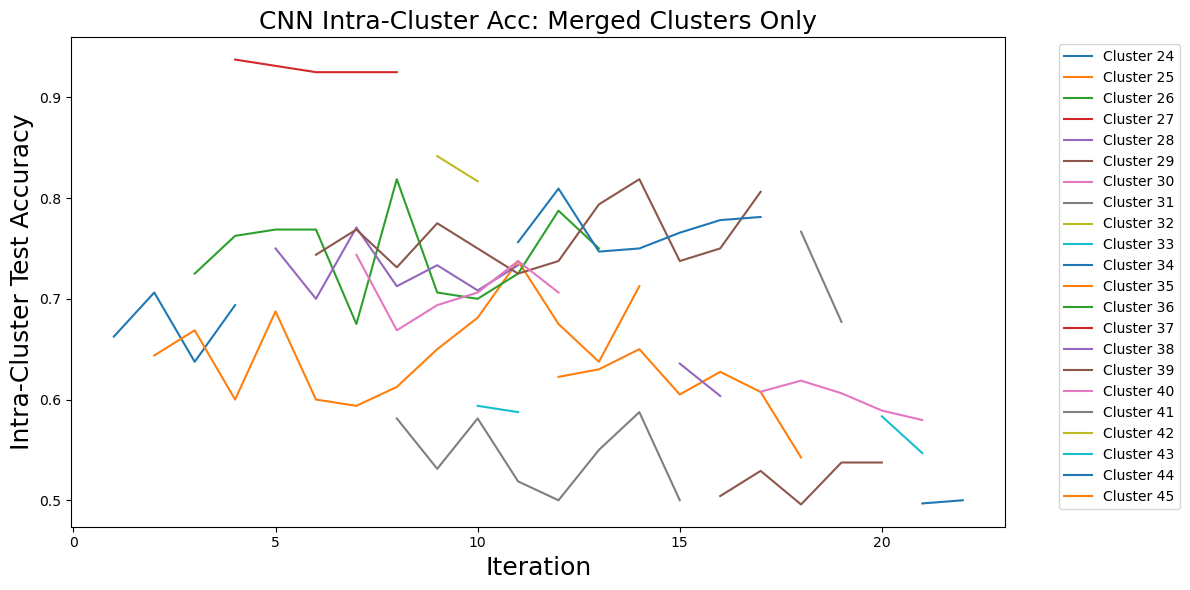

In [17]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in intra_cluster_performance:
    # Extract valid iterations and performance
    data = intra_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]==0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Intra-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Intra-Cluster Acc: Merged Clusters Only", fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

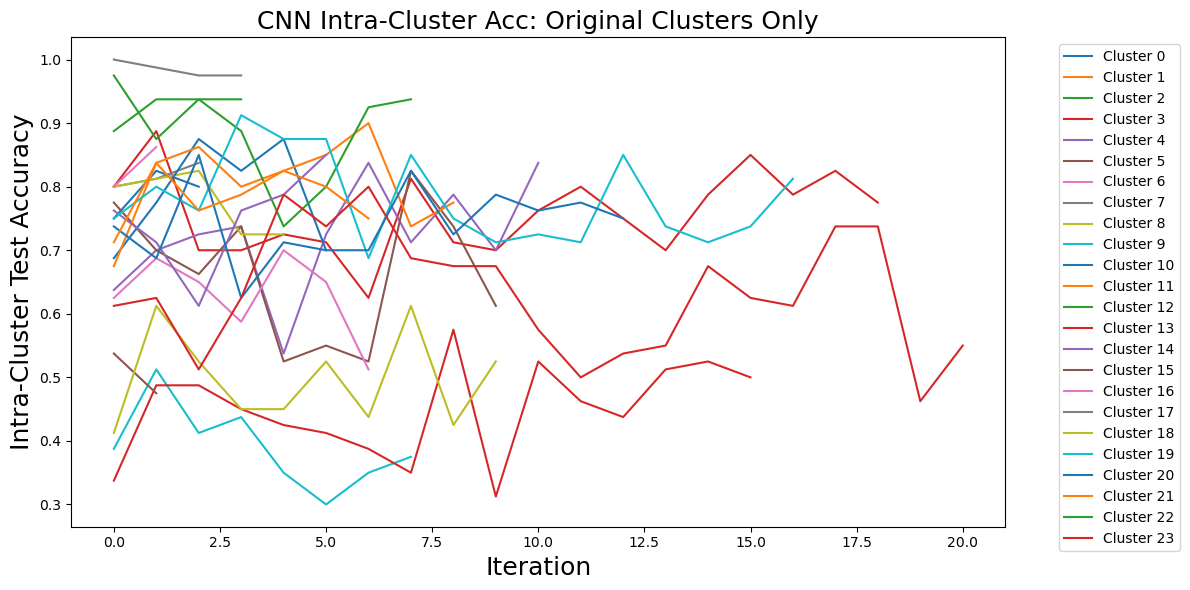

In [18]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in intra_cluster_performance:
    # Extract valid iterations and performance
    data = intra_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]!=0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Intra-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Intra-Cluster Acc: Original Clusters Only", fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## CROSS CLUSTER RESULTS

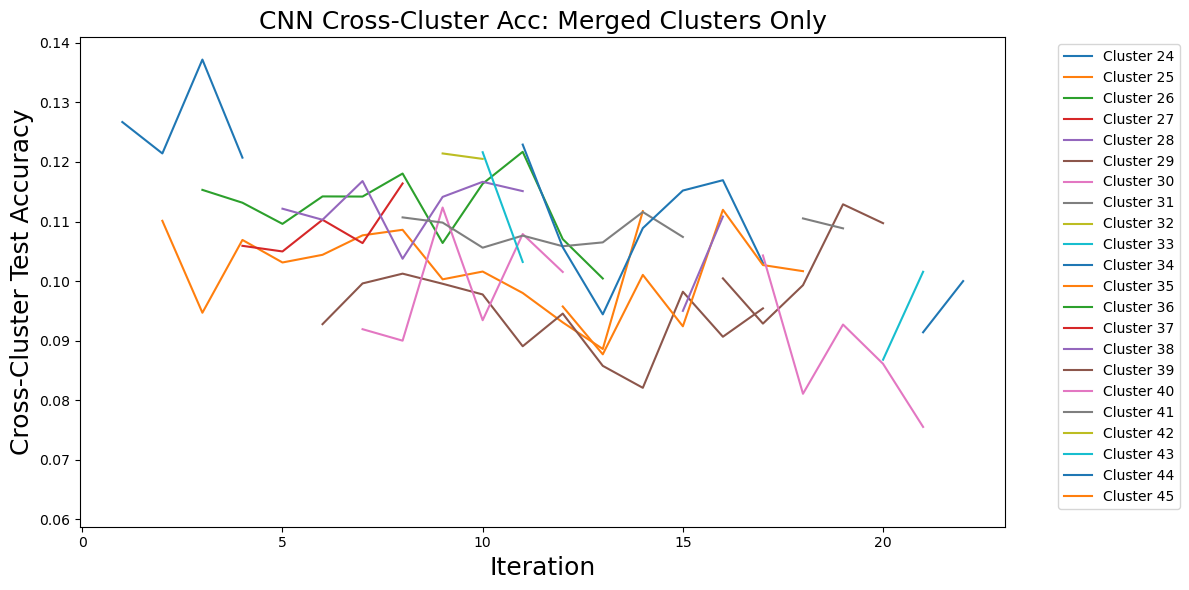

In [19]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in cross_cluster_performance:
    # Extract valid iterations and performance
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]==0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Cross-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Cross-Cluster Acc: Merged Clusters Only", fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

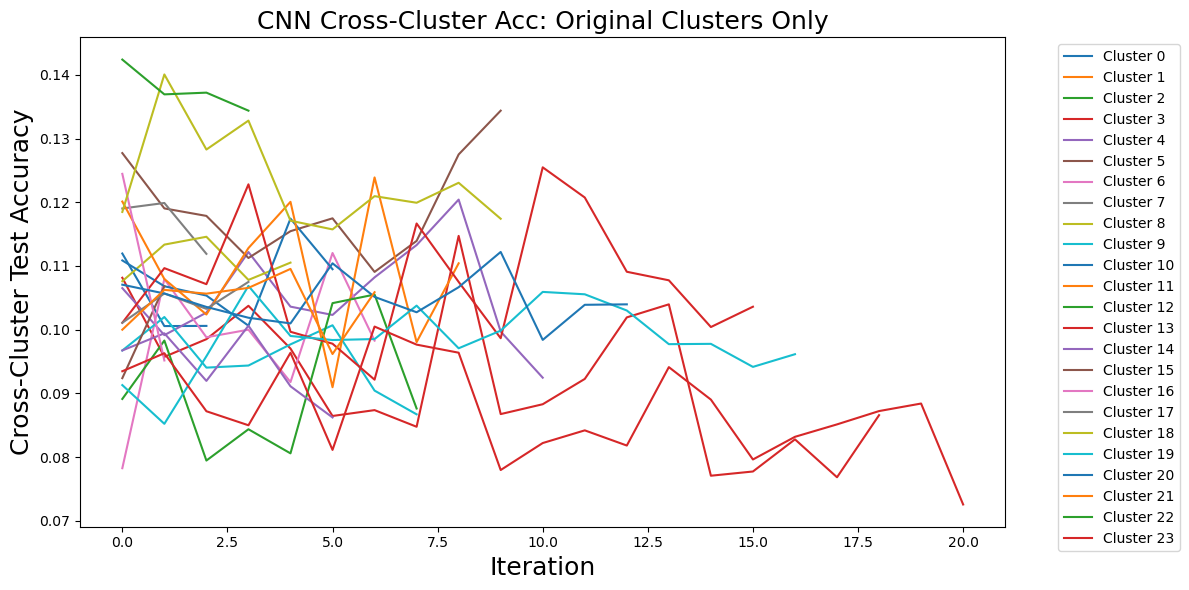

In [20]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in cross_cluster_performance:
    # Extract valid iterations and performance
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]!=0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Cross-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Cross-Cluster Acc: Original Clusters Only", fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

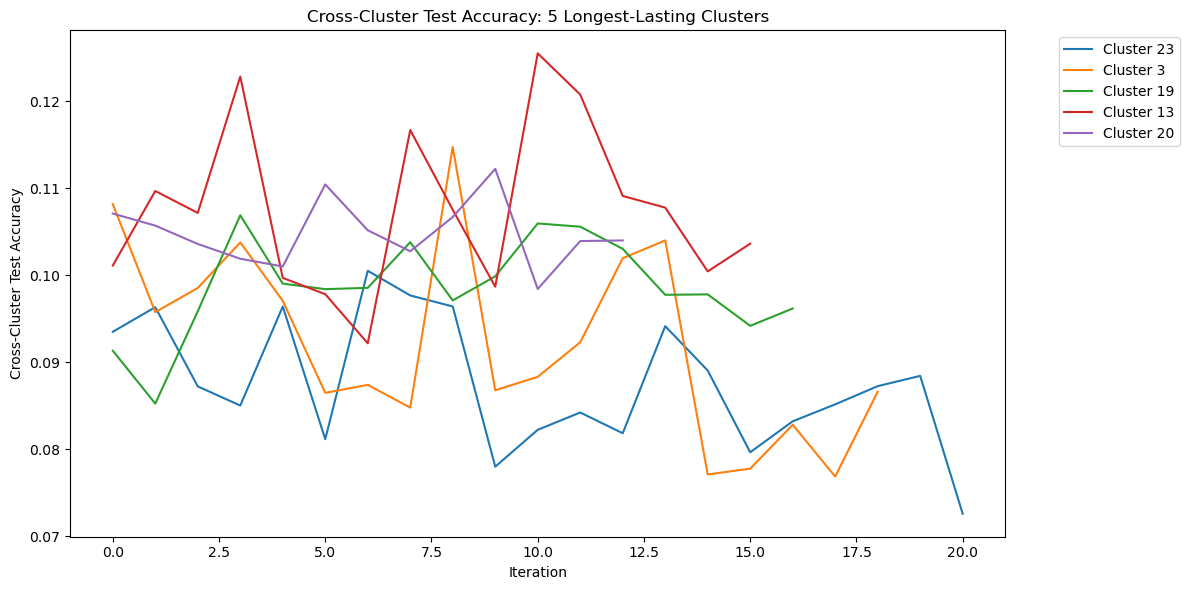

In [21]:
# Visualization
plt.figure(figsize=(12, 6))

n = 5

# Reduce number of lines (e.g., top n longest-lived clusters)
longest_clusters = sorted(cross_cluster_performance.keys(), key=lambda k: len(cross_cluster_performance[k]), reverse=True)[:n]

for cluster_id in longest_clusters:
    # Extract valid iterations and performance
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Cross-Cluster Test Accuracy")
plt.title(f"Cross-Cluster Test Accuracy: {n} Longest-Lasting Clusters")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

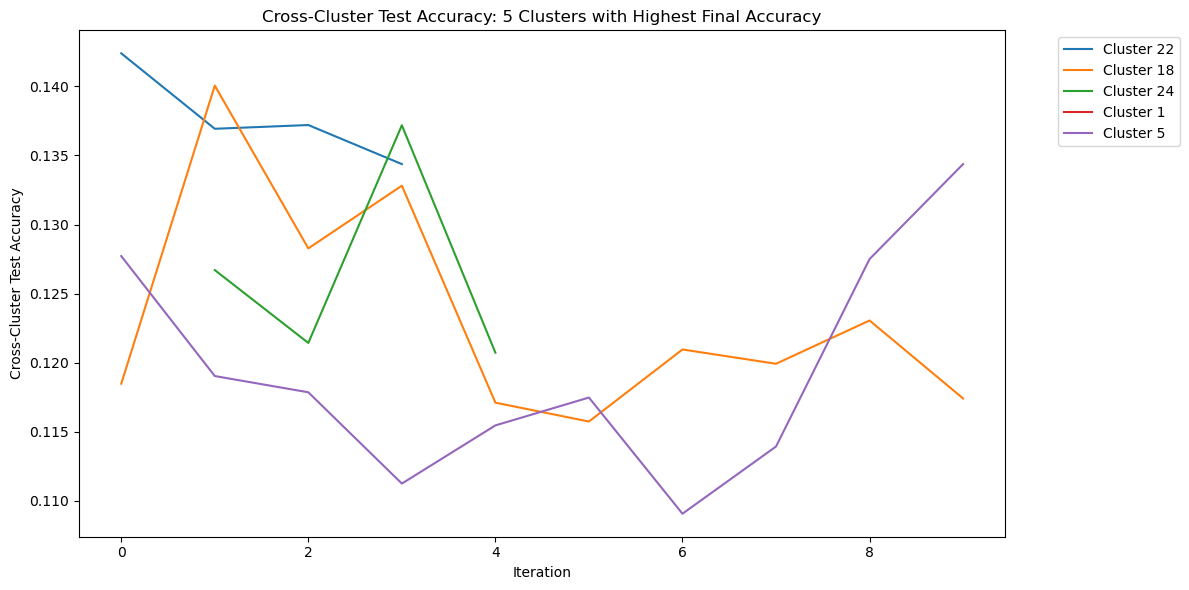

In [22]:
# Visualization
plt.figure(figsize=(12, 6))

n = 5  # Number of clusters to plot

# Find clusters with the highest final accuracies
highest_final_accuracy_clusters = sorted(
    cross_cluster_performance.keys(), 
    key=lambda k: max([perf for it, perf in cross_cluster_performance[k] if perf is not None], default=0), 
    reverse=True
)[:n]

# Plot the performance curves for these clusters
for cluster_id in highest_final_accuracy_clusters:
    # Extract valid iterations and performance
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Cross-Cluster Test Accuracy")
plt.title(f"Cross-Cluster Test Accuracy: {n} Clusters with Highest Final Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Intra-Cluster Test Accuracy Merge Tracking

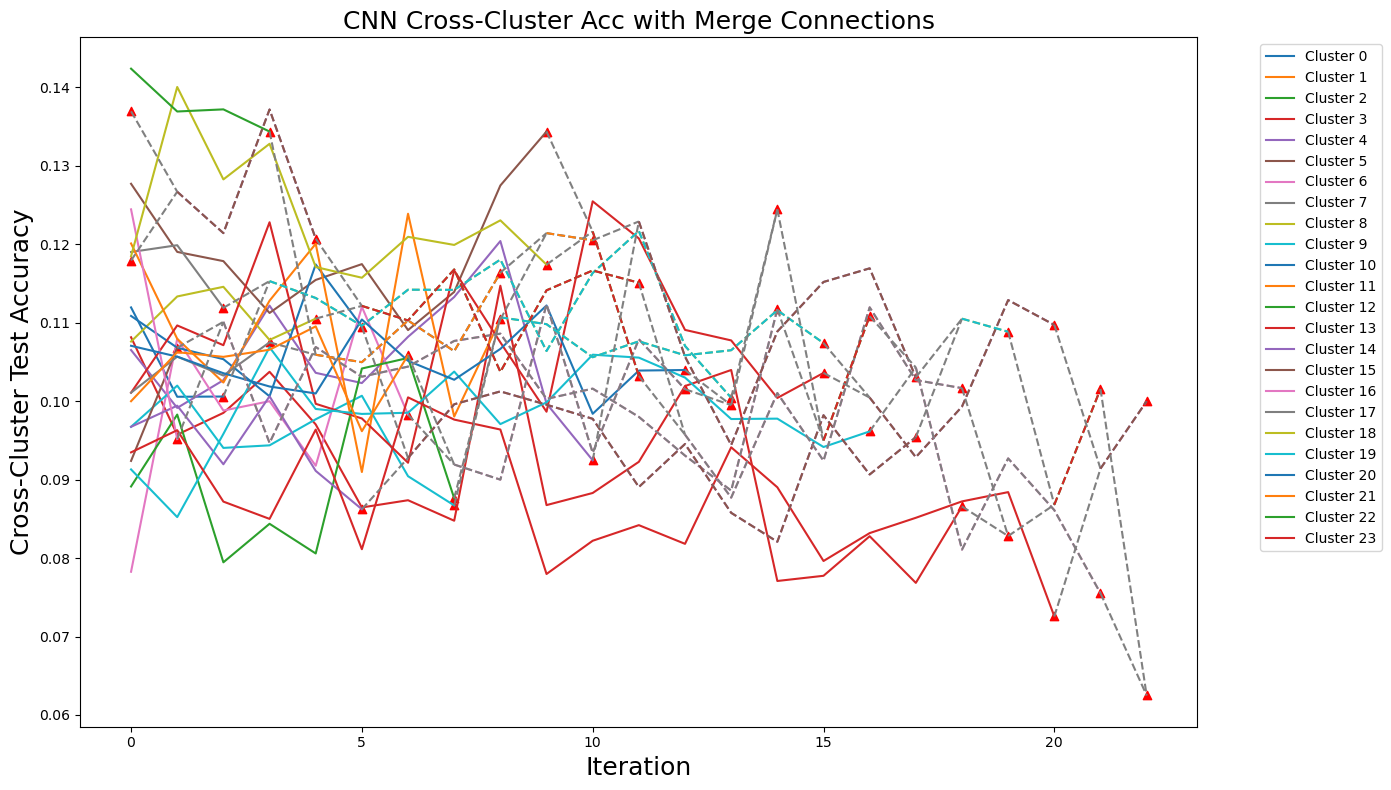

In [23]:
# Visualization with Merge Log and Connections
plt.figure(figsize=(14, 8))

# Dictionary to track the last valid point for each cluster
last_points = {}

# Plot original clusters
for cluster_id in cross_cluster_performance:
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0] != 0:
        continue

    # Plot original cluster performance
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")
    last_points[cluster_id] = (valid_iterations[-1], valid_performance[-1])  # Store the last point

# Handle merged clusters and connect original clusters
for iteration, cluster1, cluster2, _, new_cluster in merge_log:
    # Plot and connect the merged clusters
    for cluster in [cluster1, cluster2]:
        if cluster in cross_cluster_performance:
            data = cross_cluster_performance[cluster]
            merge_perf = next((perf for it, perf in data if it == iteration), None)
            if merge_perf is not None:
                plt.scatter(iteration, merge_perf, color='red', marker='^')#, label=f"Merge {cluster} → {new_cluster}")
                
        if cluster in last_points:  # If it's an original cluster
            last_iteration, last_perf = last_points[cluster]

            # Connect to the newly merged cluster
            if new_cluster in cross_cluster_performance:
                new_data = cross_cluster_performance[new_cluster]
                valid_iterations = [it for it, perf in new_data if perf is not None and it >= iteration]
                valid_performance = [perf for it, perf in new_data if perf is not None and it >= iteration]

                if valid_iterations:
                    # Draw a line connecting the original cluster to the new merged cluster
                    plt.plot(
                        [last_iteration, valid_iterations[0]],
                        [last_perf, valid_performance[0]],
                        linestyle='--', color='gray'
                    )

                    # Continue plotting the merged cluster's performance
                    plt.plot(valid_iterations, valid_performance, linestyle='--')

                # Update the last points for the newly merged cluster
                if valid_iterations:
                    last_points[new_cluster] = (valid_iterations[-1], valid_performance[-1])

# Add labels, legend, and formatting
plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Cross-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Cross-Cluster Acc with Merge Connections", fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


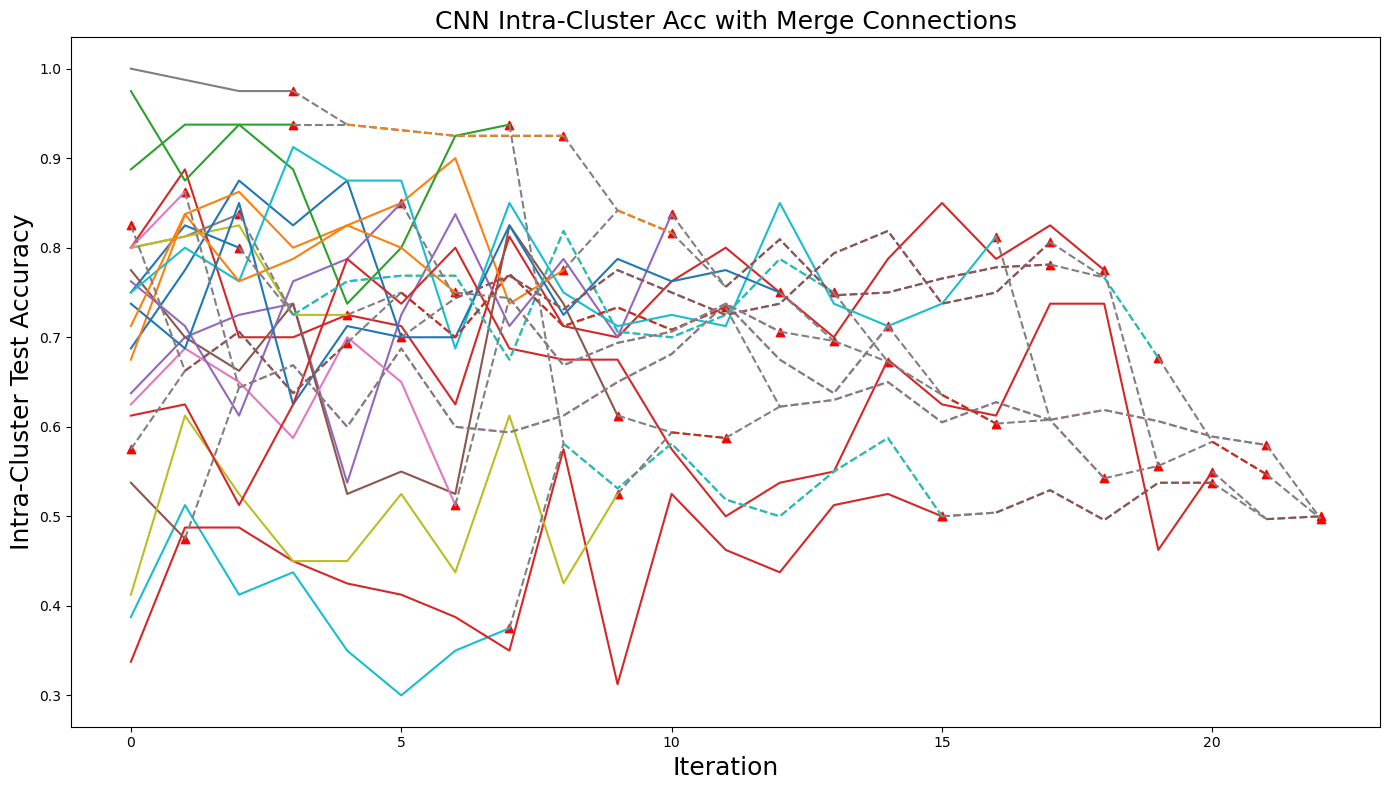

In [24]:
# Visualization with Merge Log and Connections
plt.figure(figsize=(14, 8))

# Dictionary to track the last valid point for each cluster
last_points = {}

# Plot original clusters
for cluster_id in intra_cluster_performance:
    data = intra_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0] != 0:
        continue

    # Plot original cluster performance
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")
    last_points[cluster_id] = (valid_iterations[-1], valid_performance[-1])  # Store the last point

# Handle merged clusters and connect original clusters
for iteration, cluster1, cluster2, _, new_cluster in merge_log:
    # Plot and connect the merged clusters
    for cluster in [cluster1, cluster2]:
        if cluster in intra_cluster_performance:
            data = intra_cluster_performance[cluster]
            merge_perf = next((perf for it, perf in data if it == iteration), None)
            if merge_perf is not None:
                plt.scatter(iteration, merge_perf, color='red', marker='^')#, label=f"Merge {cluster} → {new_cluster}")
                
        if cluster in last_points:  # If it's an original cluster
            last_iteration, last_perf = last_points[cluster]

            # Connect to the newly merged cluster
            if new_cluster in intra_cluster_performance:
                new_data = intra_cluster_performance[new_cluster]
                valid_iterations = [it for it, perf in new_data if perf is not None and it >= iteration]
                valid_performance = [perf for it, perf in new_data if perf is not None and it >= iteration]

                if valid_iterations:
                    # Draw a line connecting the original cluster to the new merged cluster
                    plt.plot(
                        [last_iteration, valid_iterations[0]],
                        [last_perf, valid_performance[0]],
                        linestyle='--', color='gray'
                    )

                    # Continue plotting the merged cluster's performance
                    plt.plot(valid_iterations, valid_performance, linestyle='--')

                # Update the last points for the newly merged cluster
                if valid_iterations:
                    last_points[new_cluster] = (valid_iterations[-1], valid_performance[-1])

# Add labels, legend, and formatting
plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Intra-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Intra-Cluster Acc with Merge Connections", fontsize=18)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [25]:
intra_mean_lst, cross_mean_lst, ratio_lst = compute_performance_ratios(intra_cluster_performance, cross_cluster_performance)



=== Performance Ratios ===
Cluster 0: Intra Mean = 0.792, Cross Mean = 0.104, Ratio = 7.585
Cluster 1: Intra Mean = 0.575, Cross Mean = 0.137, Ratio = 4.198
Cluster 2: Intra Mean = 0.825, Cross Mean = 0.118, Ratio = 6.995
Cluster 3: Intra Mean = 0.759, Cross Mean = 0.092, Ratio = 8.232
Cluster 4: Intra Mean = 0.722, Cross Mean = 0.106, Ratio = 6.839
Cluster 5: Intra Mean = 0.665, Cross Mean = 0.119, Ratio = 5.571
Cluster 6: Intra Mean = 0.630, Cross Mean = 0.098, Ratio = 6.422
Cluster 7: Intra Mean = 0.817, Cross Mean = 0.117, Ratio = 6.984
Cluster 8: Intra Mean = 0.778, Cross Mean = 0.111, Ratio = 7.019
Cluster 9: Intra Mean = 0.391, Cross Mean = 0.095, Ratio = 4.097
Cluster 10: Intra Mean = 0.790, Cross Mean = 0.108, Ratio = 7.282
Cluster 11: Intra Mean = 0.807, Cross Mean = 0.110, Ratio = 7.361
Cluster 12: Intra Mean = 0.884, Cross Mean = 0.091, Ratio = 9.703
Cluster 13: Intra Mean = 0.449, Cross Mean = 0.108, Ratio = 4.178
Cluster 14: Intra Mean = 0.748, Cross Mean = 0.094, Ratio 